# Prediction Pipeline

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import scipy as sc

from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from skimage import io, color, transform, feature

In [2]:
# import test image
test_img = io.imread('assets/Water_Lilly.jpg', as_gray=True)

## Image Resizing

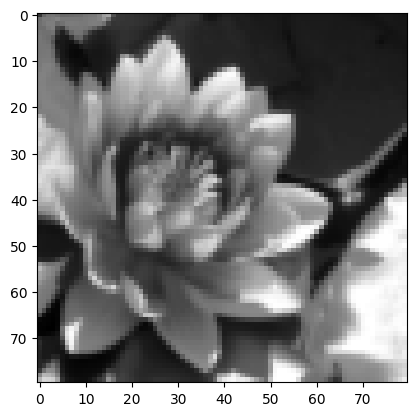

In [3]:
# the model was trained with 80x80 px images => resize inputs accordingly
test_img_resized = (transform.resize(test_img, (80, 80)) * 255).astype(np.uint8)
plt.imshow(test_img_resized, cmap='gray')
plt.savefig('assets/Scikit_Image_Model_Deployment_01.webp')

![ScikitImage Prediction Pipeline](./assets/Scikit_Image_Model_Deployment_01.webp)

## Feature Extraction

In [4]:
# extract features with optimized hyper parameters
feature_vector = feature.hog(
        test_img_resized,
        orientations=10,
        pixels_per_cell=(7, 7),
        cells_per_block=(3, 3)
).reshape(1, -1)

# ValueError: Expected 2D array, got 1D array instead:
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
# or array.reshape(1, -1) if it contains a single sample.

## Model Prediction

In [5]:
normalizer = pickle.load(open('../STEP3_Webfrontend_Deployment/static/models/sgd_model_deployment_scaler.pkl', 'rb'))
model = pickle.load(open('../STEP3_Webfrontend_Deployment/static/models/sgd_model_deployment.pkl', 'rb'))

In [6]:
('Nymphaea_Tetragona', 18.73)model.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': True,
 'epsilon': 0.1,
 'eta0': 1,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [7]:
feature_vector_scaled = normalizer.transform(feature_vector)
model.predict(feature_vector_scaled)
# array(['Nymphaea_Tetragona'], dtype='<U25')

array(['Nymphaea_Tetragona'], dtype='<U25')

In [8]:
decision_values = model.decision_function(feature_vector_scaled)
z_scores = sc.stats.zscore(decision_values.flatten())
probabilities = (sc.special.softmax(z_scores) * 100).round(2)

labels = model.classes_

probabilities_df = pd.DataFrame(probabilities, columns=['probability [%]'], index=labels)
probabilities_df.sort_values(by='probability [%]', ascending=False)[:5]

,probability [%]
Nymphaea_Tetragona,18.73
Datura_Metel,15.10
Protea_Cynaroides,4.51
Paphiopedilum_Micranthum,4.45
Anthurium_Andraeanum,4.30


__Top 5 Predictions__:


|  | probability [%] |
| -- | -- |
| Nymphaea_Tetragona | 18.73 |
| Datura_Metel | 15.10 |
| Protea_Cynaroides | 4.51 |
| Paphiopedilum_Micranthum | 4.45 |
| Anthurium_Andraeanum | 4.30 |

In [9]:
# https://stackoverflow.com/questions/52644035/how-to-show-a-pandas-dataframe-into-a-existing-flask-html-table
probabilities_dict = probabilities_df.sort_values(by='probability [%]', ascending=False)[:5].to_dict()
probabilities_dict.values()

# dict_values([{'Nymphaea_Tetragona': 18.73, 'Datura_Metel': 15.1, 'Protea_Cynaroides': 4.51, 'Paphiopedilum_Micranthum': 4.45, 'Anthurium_Andraeanum': 4.3}])

dict_values([{'Nymphaea_Tetragona': 18.73, 'Datura_Metel': 15.1, 'Protea_Cynaroides': 4.51, 'Paphiopedilum_Micranthum': 4.45, 'Anthurium_Andraeanum': 4.3}])

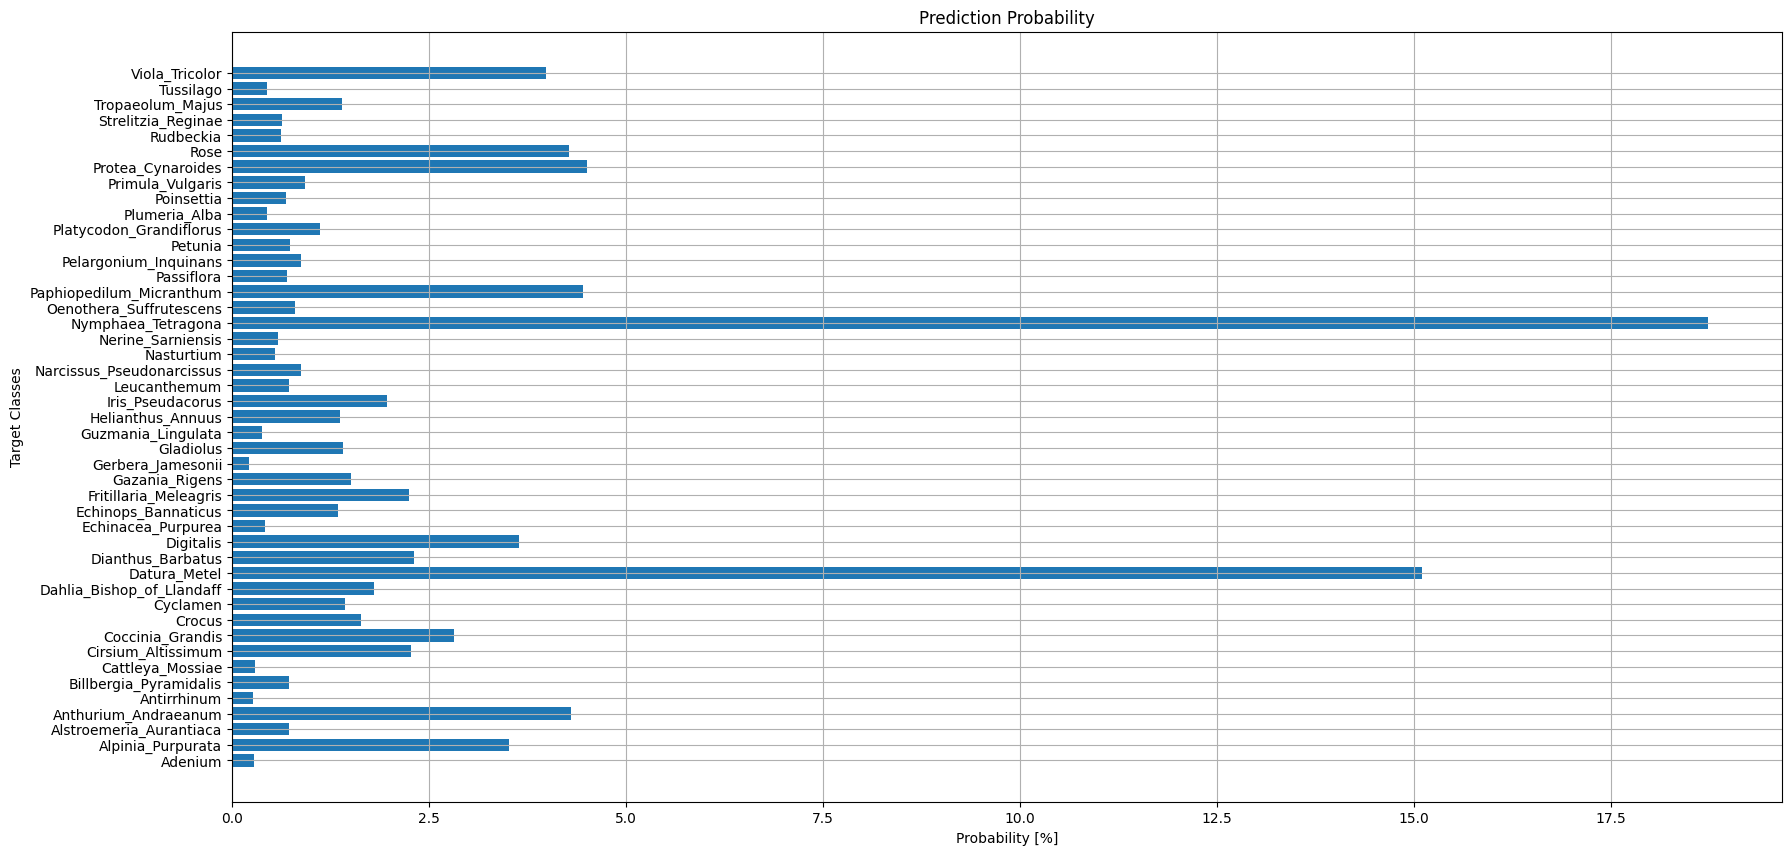

In [10]:
plt.figure(figsize=(20,10))
plt.barh(labels, probabilities)
plt.ylabel('Target Classes')
plt.xlabel('Probability [%]')
plt.title('Prediction Probability')
plt.grid()
plt.savefig('assets/Scikit_Image_Model_Deployment_02.webp')

![ScikitImage Prediction Pipeline](./assets/Scikit_Image_Model_Deployment_02.webp)

## Building the Prediction Pipeline

In [11]:
def prediction_pipeline(img_path, normalizer, model):
    img = io.imread(img_path, as_gray=True)
    img_resized = (transform.resize(img, (80, 80)) * 255).astype(np.uint8)
    
    feature_vector = feature.hog(
            test_img_resized,
            orientations=10,
            pixels_per_cell=(7, 7),
            cells_per_block=(3, 3)
    ).reshape(1, -1)
    
    feature_vector_scaled = normalizer.transform(feature_vector)
    model.predict(feature_vector_scaled)
    
    decision_values = model.decision_function(feature_vector_scaled)
    z_scores = sc.stats.zscore(decision_values.flatten())
    probabilities = (sc.special.softmax(z_scores) * 100).round(2)
    
    labels = model.classes_

    probabilities_df = pd.DataFrame(probabilities, columns=['probability [%]'], index=labels)
    top5predictions = probabilities_df.sort_values(
        by='probability [%]', ascending=False
    )[:5].to_dict().values()
    
    return top5predictions

In [12]:
# test pipeline
prediction_pipeline('assets/Water_Lilly.jpg', normalizer, model)

# dict_values([{'Nymphaea_Tetragona': 18.73, 'Datura_Metel': 15.1, 'Protea_Cynaroides': 4.51, 'Paphiopedilum_Micranthum': 4.45, 'Anthurium_Andraeanum': 4.3}])

dict_values([{'Nymphaea_Tetragona': 18.73, 'Datura_Metel': 15.1, 'Protea_Cynaroides': 4.51, 'Paphiopedilum_Micranthum': 4.45, 'Anthurium_Andraeanum': 4.3}])

In [13]:
results = prediction_pipeline('assets/Water_Lilly.jpg', normalizer, model)

In [14]:
list(list(results)[0].items())[0]
# ('Nymphaea_Tetragona', 18.73)

('Nymphaea_Tetragona', 18.73)